# Introduction: Home Credit Default Risk Competition
Dans ce Notebook, nous participerons au concours de Machine Learning sur le risque de défaut de crédit immobilier actuellement hébergé sur Kaggle. L'objectif de ce concours est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera ou non en mesure de rembourser un prêt. Il s’agit d’une tâche de classification supervisée standard :

* __Supervisé__ : les étiquettes sont incluses dans les données d'entraînement et le but est de former un modèle pour apprendre à prédire les étiquettes à partir des fonctionnalités
* __Classification__ : Le label est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt)

# Data
Les données sont fournies par [Home Credit](http://www.homecredit.net/about-us.aspx), un service dédié aux lignes de crédit (prêts) fournies à la population non bancarisée. Prédire si un client remboursera ou non un prêt ou aura des difficultés est un besoin commercial essentiel, et Home Credit organise ce concours sur Kaggle pour voir quels types de modèles la communauté d'apprentissage automatique peut développer pour les aider dans cette tâche.

Il existe 7 sources de données différentes :

* application_train/application_test : les principales données de formation et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la fonctionnalité « SK_ID_CURR ». Les données de la demande de formation sont accompagnées du 'TARGET' indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
* bureau : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent possède sa propre ligne dans le bureau, mais un prêt dans les données de candidature peut avoir plusieurs crédits précédents.
* bureau_balance : données mensuelles sur les crédits précédents en bureau. Chaque ligne représente un mois d'un crédit précédent, et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
* previous_application : demandes précédentes de prêts chez Home Credit des clients qui ont des prêts dans les données de la demande. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts précédents. Chaque application précédente comporte une ligne et est identifiée par la fonctionnalité « SK_ID_PREV ».
* POS_CASH_BALANCE : données mensuelles sur les précédents points de vente ou prêts de trésorerie que les clients ont contractés avec Home Credit. Chaque ligne correspond à un mois d'un point de vente ou d'un prêt de trésorerie précédent, et un seul prêt précédent peut comporter plusieurs lignes.
* credit_card_balance : données mensuelles sur les cartes de crédit précédentes que les clients ont eues avec Home Credit. Chaque ligne représente un mois du solde d’une carte de crédit, et une seule carte de crédit peut comporter plusieurs lignes.
* installments_payment : historique des paiements des prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

## Metric: ROC AUC

Une fois que nous avons une compréhension des données (la lecture des [descriptions des colonnes](https://www.kaggle.com/c/home-credit-default-risk/data) aide énormément), nous devons comprendre la métrique en laquelle notre soumission est jugée. Dans ce cas, il s'agit d'une métrique de classification courante connue sous le nom de [Zone caractéristique de fonctionnement du récepteur sous la courbe (ROC AUC, également parfois appelée AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

La [courbe des caractéristiques de fonctionnement du récepteur (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) représente graphiquement le taux de vrais positifs par rapport au taux de faux positifs.

L' [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) s'explique par son nom ! Il s'agit simplement de l'aire sous la courbe ROC. (Il s'agit de l'intégrale de la courbe.) Cette métrique est comprise entre 0 et 1, un meilleur modèle ayant un score plus élevé. Un modèle qui devine simplement au hasard aura une ROC AUC de 0,5.

Lorsque nous mesurons un classificateur selon le ROC AUC, nous ne générons pas de prédictions 0 ou 1, mais plutôt une probabilité comprise entre 0 et 1. Cela peut prêter à confusion car nous aimons généralement penser en termes de précision, mais lorsque nous rencontrons des problèmes avec des classes déséquilibrées (nous verrons que c'est le cas), la précision n'est pas la meilleure mesure. Par exemple, si je voulais construire un modèle capable de détecter les terroristes avec une précision de 99,9999 %, je créerais simplement un modèle qui prédirait que chaque personne n'est pas un terroriste. Clairement, cela ne serait pas efficace (le rappel serait nul) et nous utilisons des métriques plus avancées telles que le ROC AUC ou le [score F1](https://en.wikipedia.org/wiki/F1_score) pour refléter plus précisément le performances d'un classificateur. Un modèle avec une AUC ROC élevée aura également une grande précision, mais [l'AUC ROC est une meilleure représentation des performances du modèle.](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)

Commençons à explorer les données. Dans ce notebook, comme mentionné précédemment, nous nous en tiendrons aux principales sources de données et aux modèles simples sur lesquels nous pourrons nous appuyer dans nos travaux futurs. 

## Import
Nous utiliserons une stack de Data Science habituelle : `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [209]:
#manipulation des données
import numpy as np
import pandas as pd 

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes 
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Import du Dataset
Tout d’abord, nous pouvons lister tous les fichiers de données disponibles. Il y a au total 10 fichiers : 1 fichier principal pour l'entrainement (avec cible), 1 fichier principal pour les tests (sans la cible), 1 exemple de fichier de soumission et 7 autres fichiers contenant des informations supplémentaires sur chaque prêt.

In [210]:
print(os.listdir("./Home_Credit_Default_Risk/"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [211]:
app_train = pd.read_csv('./Home_Credit_Default_Risk/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

Les données d'entraînement contiennent 307 511 observations (chacune étant un emprunt distinct) et 122 caractéristiques (variables), y compris la `TARGET` (l'étiquette que nous voulons prédire).

In [212]:
app_test = pd.read_csv('./Home_Credit_Default_Risk/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

L'ensemble de tests est considérablement plus petit et ne dispose pas de colonne `TARGET`.

# Analyse exploratoire des données
L'analyse exploratoire des données (AED) est un processus dans lequel nous calculons des statistiques et réalisons des opérations pour trouver les tendances, les anomalies, les modèles ou les relations au sein des données. L’objectif de l’AED est d’apprendre ce que les données peuvent nous raconter. Cela commence généralement par un aperçu préliminaire, puis nous nous concentrons sur des domaines spécifiques à mesure que nous trouvons des domaines de données intéressant pour notre étude. Les résultats peuvent être intéressants en eux-mêmes, ou ils peuvent être utilisés pour éclairer nos choix de modélisation, par exemple en nous aidant à décider quelles fonctionnalités utiliser.

## Examen de la distribution de la colonne TARGET
L'objectif est de pouvoir prédire : soit un 0 pour le prêt remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d’abord examiner le nombre de prêts entrant dans chaque catégorie.

In [213]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

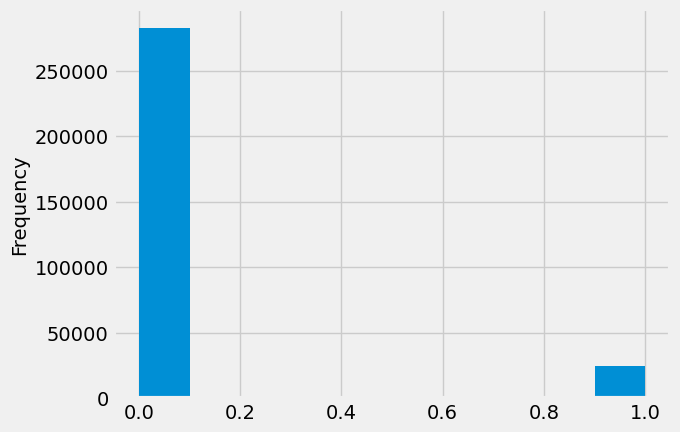

In [214]:
app_train['TARGET'].astype(int).plot.hist();

À partir de ces informations, nous voyons qu'il y a un [_problème de déséquilibre de classe_](https://www.aquiladata.fr/insights/comment-gerer-le-desequilibre-des-classes-dans-un-jeu-de-donnees/). Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons [pondérer les classes](https://kobia.fr/imbalanced-data-et-machine-learning/) par leur représentation dans les données pour refléter ce déséquilibre.

## Examen des valeurs manquantes
Ensuite, nous pouvons examiner le nombre et le pourcentage de valeurs manquantes dans chaque colonne.

In [215]:
# Fonction permettant de calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Total de valeurs manquantes
        mis_val = df.isnull().sum()
        
        # Percentage de valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Créer un tableau des résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Changer le nom des colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valeurs manquantes', 1 : '% de valeurs manquantes'})
        
        # Trier le tableau par ordre décroissant 
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% de valeurs manquantes', ascending=False).round(1)
        
        # Affichage des informations 
        print ("Le Dataframe a " + str(df.shape[1]) + " colonnes.\n"      
            "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes qui ont des valeurs manquantes.")
        
        # Return le tableau des valeurs manquantes
        return mis_val_table_ren_columns

In [216]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Le Dataframe a 122 colonnes.
Il y a 67 colonnes qui ont des valeurs manquantes.


Valeurs manquantes  % de valeurs manquantes
COMMONAREA_MEDI                       214865                     69.9
COMMONAREA_AVG                        214865                     69.9
COMMONAREA_MODE                       214865                     69.9
NONLIVINGAPARTMENTS_MEDI              213514                     69.4
NONLIVINGAPARTMENTS_MODE              213514                     69.4
NONLIVINGAPARTMENTS_AVG               213514                     69.4
FONDKAPREMONT_MODE                    210295                     68.4
LIVINGAPARTMENTS_MODE                 210199                     68.4
LIVINGAPARTMENTS_MEDI                 210199                     68.4
LIVINGAPARTMENTS_AVG                  210199                     68.4
FLOORSMIN_MODE                        208642                     67.8
FLOORSMIN_MEDI                        208642                     67.8
FLOORSMIN_AVG                         208642                     67.8
YEARS_BUILD_MODE                      204488                     66.5
YEARS_BUILD_MEDI                      204488                     66.5
YEARS_BUILD_AVG                       204488                     66.5
OWN_CAR_AGE                           202929                     66.0
LANDAREA_AVG                          182590                     59.4
LANDAREA_MEDI                         182590                     59.4
LANDAREA_MODE                         182590                     59.4

Lorsque nous instancierons nos modèles d’apprentissage automatique, nous pourrons combler ces valeurs manquantes (appelée imputation). Dans des travaux ultérieurs, nous utiliserons des modèles tels que XGBoost qui peuvent [gérer les valeurs manquantes sans nécessiter d'imputation](https://datascientest.com/xgboost-grand-gagnant-des-competitions-machine-learning-algorithme). Une autre option consisterait à supprimer les colonnes avec un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. Par conséquent, nous conserverons toutes les colonnes pour le moment.

In [217]:
app_train[app_train.duplicated()]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, ...]
Index: []

[0 rows x 122 columns]

Pas d'individu dupliqué nous pouvons poursuivre notre travail

## Type des variables
Regardons le nombre de variables de chaque type de données. `int64` et `float64` sont des variables numériques ([qui peuvent être discrètes ou continues](https://support.minitab.com/fr-fr/minitab/21/help-and-how-to/statistical-modeling/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/)). Les variables `object` contiennent des chaînes de caractères et sont des [caractéristiques catégorielles.](https://datascience.eu/fr/mathematiques-et-statistiques/donnees-categorielles/) .

In [218]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Examinons maintenant le nombre d'entrées uniques dans chacune des colonnes `objet`(catégorielle).

In [219]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [220]:
app_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Il semblerait que la variable `CODE_GENDER` a 4 valeurs manquantes, pour simplifier notre travail nous supprimons les individus possèdant des valeurs manquantes.

In [221]:
index_drop = app_train[app_train['CODE_GENDER'] == 'XNA'].index
app_train.drop(index_drop, inplace=True)

Pour le reste la plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques. Nous devrons trouver un moyen de gérer ces variables catégorielles.

## Encodage des variables catégorielles
Avant d’aller plus loin, nous devons traiter des variables catégorielles. Un modèle d'apprentissage automatique ne peut malheureusement pas gérer des variables catégorielles (sauf pour certains modèles tels que [LightGBM](https://pro.arcgis.com/fr/pro-app/latest/tool-reference/geoai/how-lightgbm-works.htm#:~:text=LightGBM%20est%20une%20m%C3%A9thode%20d,la%20classification%20et%20la%20r%C3%A9gression.)). Par conséquent, nous devons trouver un moyen d'encoder (représenter) ces variables sous forme de nombres avant de les transmettre au modèle. Il existe deux manières principales de réaliser ce processus :

* Encodage des étiquettes : attribuez à chaque catégorie unique une variable catégorielle avec un entier. Aucune nouvelle colonne n'est créée. Un exemple est montré ci-dessous

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* Encodage One-Hot: créez une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne pour sa catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

Le problème avec l'encodage des étiquettes est qu’il donne aux catégories un ordre arbitraire. La valeur attribuée à chacune des catégories est aléatoire et ne reflète aucun aspect inhérent à la catégorie. Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le data scientist un 1, mais si nous refaisons le même processus, les étiquettes pourraient être inversées ou complètement différentes. L'affectation réelle des entiers est arbitraire. Par conséquent, lorsque nous effectuons un encodage d'étiquettes, le modèle peut utiliser la valeur relative de la caractéristique (par exemple programmeur = 4 et data scientist = 1) pour attribuer des poids qui ne correspondent pas à ce que nous souhaitons. Si nous n'avons que deux valeurs uniques pour une variable catégorielle (telle que Homme/Femme), alors l'encodage des étiquettes est correct, mais pour plus de 2 catégories uniques, l'encodage One-Hot est l'option la plus sûre.

Il existe un certain débat sur les mérites relatifs de ces approches, et certains modèles peuvent traiter sans problème des variables catégorielles codées par des étiquettes. [Voici une bonne discussion sur Stack Overflow](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). Mon opinion est que pour les variables catégorielles avec de nombreuses classes, l'encodage One-Hot est l'approche la plus pertinente car elle n'impose pas de valeurs arbitraires aux catégories. Le seul inconvénient de l'encodage One-Hot est que le nombre de caractéristiques (dimensions des données) peut s'accroitre rapidement avec des variables catégorielles comportant de nombreuses catégories. Pour résoudre ce problème, nous pouvons effectuer un encodage One-Hot suivi d'une [ACP](https://datascientest.com/acp) ou d'autres [méthodes de réduction de dimensionnalité](https://dataanalyticspost.com/Lexique/reduction-de-dimensionnalite/) pour réduire le nombre de dimensions (tout en essayant de préserver les informations).

Dans ce Notebook, nous utiliserons l'encodage des étiquettes pour toutes les variables catégorielles avec seulement 2 catégories et l'encodage One-Hot pour toutes les variables catégorielles avec plus de 2 catégories. Ce processus devra peut-être changer à mesure que nous avancerons dans le projet.

## Encodate par étiquettes et encodage One-Hot
Implémentons la méthode décrite ci-dessus : pour toute variable catégorielle (`dtype == object`) avec 2 catégories uniques, nous utiliserons l'encodage par étiquette, et pour toute variable catégorielle avec plus de 2 catégories uniques, nous utiliserons l'encodage one-hot.

Pour l'encodage des étiquettes, nous utilisons le `LabelEncoder` de `Scikit-Learn` et pour l'encodage one-Hot, la fonction `get_dummies(df)` de `pandas`. 

In [222]:
# Création de l'encodeur d'étiquette
le = LabelEncoder()
le_count = 0

# Itérer sur les colonnes
for col in app_train:
    if app_train[col].dtype == 'object':
        # si il y a 2 ou moins de catégorie unique
        if len(list(app_train[col].unique())) <= 2:
            # on applique l'encodeur d'étiquettes sur les données
            le.fit(app_train[col])
            # on applique l'encodeur sur les dataset de test et d'entrainement
            app_train[col] = le.transform(app_train[col])
            
            # on conserve le nombre de colonne encodé par étiquettes
            le_count += 1
            
print('%d colonnes encodées par étiquette.' % le_count)

4 colonnes encodées par étiquette.


In [223]:
# Encodage One-Hot des autres variables catégorielles
app_train = pd.get_dummies(app_train)

print('Training Features shape: ', app_train.shape)

Training Features shape:  (307507, 241)


## Analyse exploratoire des données
### Anomalies
Un détail a surveiller lors d'une AED est le cas des données aberrantes ou atypique. Cela peut être dû à des chiffres mal saisis, à des erreurs dans l'équipement de mesure ou à des mesures valides mais atypique. Une façon de prendre en charge quantitativement les anomalies consiste à examiner les statistiques d'une colonne à l'aide de la méthode `describe`. Nous pouvons analyser la répartition des valeurs des différentes variables en commençant par `DAYS_BIRTH`. Les nombres dans cette variable sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année :

In [224]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Les âges des individus semblent raisonnables. Il n’y a pas de valeurs aberrantes pour la variable âge. Analysons la répartition des valeurs de la variables `DAYS_EMPLOYED`.

In [225]:
app_train['DAYS_EMPLOYED'].describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

La répartition des valeurs de cette variable ne semble pas être correcte, on constate des valeurs négative en plus des valeurs aberrantes.

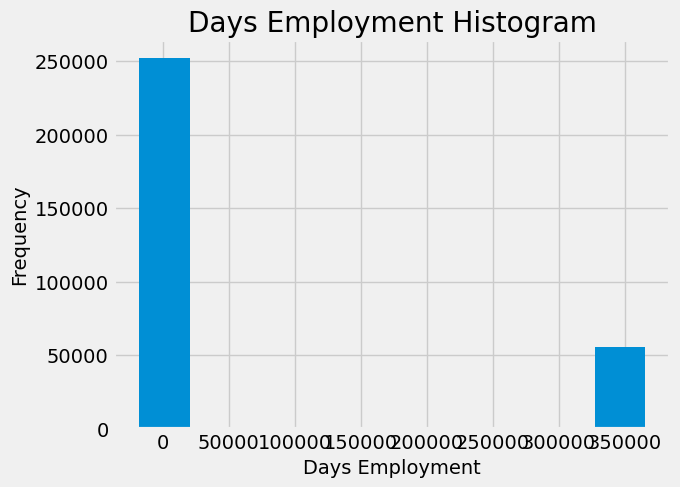

In [226]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Nous observons les données aberrantes pour voir si le taux de défaut est plus important parmis elle que parmis les autres.

In [227]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print("Le pourcentage de défaut parmis les données non-aberrantes est de %0.2f%% de l'ensemble des crédits" % (100 * non_anom['TARGET'].mean()))
print("Le pourcentage de défaut parmis les données aberrantes est de %0.2f%% de l'ensemble des crédits" % (100 * anom['TARGET'].mean()))
print('Il y a %d valeurs aberrantes' % len(anom))

Le pourcentage de défaut parmis les données non-aberrantes est de 8.66% de l'ensemble des crédits
Le pourcentage de défaut parmis les données aberrantes est de 5.40% de l'ensemble des crédits
Il y a 55374 valeurs aberrantes


Nous pouvons constater que les individus ayant des valeurs aberrantes ont une taux de défaut plus faible que les autres.

La gestion des valeurs aberrantes dépend du contexte, sans règles définies, l'une des approches les plus pertinentes consiste à définir les valeurs aberrantes sur une valeur manquante, puis à les remplacer (à l'aide de l'imputation) avant d'utiliser un algorithme de Machine Learning. Dans ce cas, puisque toutes les valeurs aberrantes ont exactement la même valeur, nous les remplacerons avec la même valeur dans le cas où tous ces prêts auraient une raison particulière de partager cette valeur aberrante. Les valeurs aberrante semblent avoir une intérêt particulier, nous souhaitons indiquer au modèle de Machine Learning les individus qui possèdaient ou non une valeur aberrante. Nous remplirons donc les valeurs aberrantes avec une valeur manquante (np.nan), puis nous créerons une nouvelle colonne booléenne indiquant si la valeur était aberrante ou non.

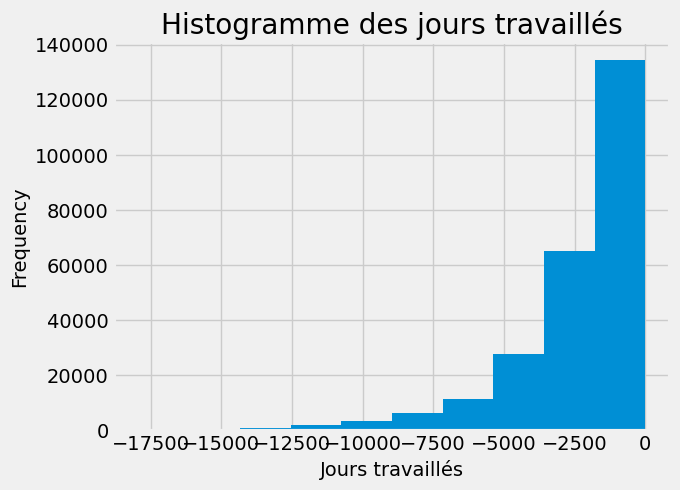

In [228]:
# Créer une colonne pour signaler si l'individu possèdaient une valeur aberrante
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Remplacement des valeurs aberrantes par des nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme des jours travaillés');
plt.xlabel('Jours travaillés');

La distribution semble être plus conforme à ce à quoi nous nous attendions, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine aberrante.

### Correlations

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, continuons avec l'AED. Une façon d’essayer de comprendre les données consiste à rechercher des corrélations entre les variables et la `TARGET`. Nous pouvons calculer le coefficient de corrélation entre chaque variable et la `TARGET` en utilisant la méthode dataframe `.corr`.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la pertinence d'une variable, mais il nous donne une idée des relations possibles au sein des données. Certaines [interprétations générales de la valeur absolue du coefficient de corrélation] (https://www.nagwa.com/fr/explainers/143190760373/) sont :

* .00-.19 “Aucune corrélation”
*  .20-.39 “Faible corrélation”
*  .40-.59 “Corrélation modérée”
*  .60-.79 “Forte corrélation”
* .80-1.0 “Très forte corrélation”

Il existe deux types de corrélation :
* Corrélation de Pearson : Utilisée pour évaluer la corrélation linéaire entre deux variables continues normalement distribuées.
* Corrélation de Spearman : Utilisée pour évaluer la relation monotone (pas nécessairement linéaire) entre deux variables, surtout lorsque les données ne sont pas normalement distribuées.

Nous avons pu remarquer avec la variable des âges que toutes les variables n'était pas normalement distribué et que la variable `TARGET` était déséquilibrée. Nous utiliserons alors la corrélation de Spearman pour étudier les corrélations entre les différentes variables.

In [229]:
categorial_columns = app_train.columns[(app_train.min() == 0) & (app_train.max() == 1)]
categorial_columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       ...
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'DAYS_EMPLOYED_ANOM'],
      dtype='object', length=212)

In [230]:
non_categorial_columns = app_train.columns[~((app_train.min() == 0) & (app_train.max() == 1))]
non_categorial_columns

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

Nous effctuons d'abord une analyse de la corrélation entre les variables catégorielles et la `TARGET`

In [231]:
# Trouver les corrélation avec la target et les trier par ordre croissant
correlations = app_train[categorial_columns].corrwith(app_train['TARGET'],\
                                                      method='spearman').sort_values()

# Affichage
print('Correlations positive:\n', correlations.tail(15))
print('\nCorrelations Négative:\n', correlations.head(15))

Correlations positive:
 OCCUPATION_TYPE_Low-skill Laborers                   0.027609
FLAG_WORK_PHONE                                      0.028533
ORGANIZATION_TYPE_Self-employed                      0.029137
NAME_HOUSING_TYPE_With parents                       0.029965
OCCUPATION_TYPE_Drivers                              0.030303
LIVE_CITY_NOT_WORK_CITY                              0.032517
OCCUPATION_TYPE_Laborers                             0.043017
FLAG_DOCUMENT_3                                      0.044341
REG_CITY_NOT_LIVE_CITY                               0.044394
FLAG_EMP_PHONE                                       0.045984
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049822
REG_CITY_NOT_WORK_CITY                               0.050992
CODE_GENDER                                          0.054710
NAME_INCOME_TYPE_Working                             0.057483
TARGET                                               1.000000
dtype: float64

Correlations Négative:
 NAME_E

Puis nous effctuons une analyse de la corrélation entre les variables quantitative et la `TARGET`

In [232]:
# Trouver les corrélation avec la target et les trier par ordre croissant
correlations = app_train[non_categorial_columns].corrwith(app_train['TARGET'],\
                                                         method='spearman').sort_values()

# Affichage
print('Correlations positive:\n', correlations.tail(15))
print('\nCorrelations Négative:\n', correlations.head(15))

Correlations positive:
 CNT_FAM_MEMBERS                0.007009
OBS_60_CNT_SOCIAL_CIRCLE       0.009225
OBS_30_CNT_SOCIAL_CIRCLE       0.009376
AMT_REQ_CREDIT_BUREAU_YEAR     0.019465
CNT_CHILDREN                   0.020077
DEF_60_CNT_SOCIAL_CIRCLE       0.030913
DEF_30_CNT_SOCIAL_CIRCLE       0.032204
DAYS_REGISTRATION              0.040172
DAYS_ID_PUBLISH                0.052535
OWN_CAR_AGE                    0.052932
DAYS_LAST_PHONE_CHANGE         0.053711
REGION_RATING_CLIENT           0.058911
REGION_RATING_CLIENT_W_CITY    0.060938
DAYS_BIRTH                     0.078331
DAYS_EMPLOYED                  0.080269
dtype: float64

Correlations Négative:
 EXT_SOURCE_3                 -0.166336
EXT_SOURCE_1                 -0.151129
EXT_SOURCE_2                 -0.147331
AMT_GOODS_PRICE              -0.031495
REGION_POPULATION_RELATIVE   -0.030558
HOUR_APPR_PROCESS_START      -0.022912
AMT_INCOME_TOTAL             -0.018102
AMT_CREDIT                   -0.017539
AMT_REQ_CREDIT_BUREAU_QR

Nous remarquons que la variable `DAYS_BIRTH` et la variable `DAY_EMPLOYED` ont la corrélation la plus importante avec la `TARGET`. En étudiant la documentation, la variable `DAYS_BIRTH` correspond à l'âge en jours du client au moment du prêt en nombres négatifs, ce qui signifie qu'à mesure que le client vieillit, il est moins susceptible de faire défaut sur son prêt (c'est-à-dire `TARGET` == 0). En prenant les valeurs absolues de la variable et la corrélation sera alors négative.

### Effet de l'âge sur le remboursement

In [233]:
# On transforme les valeurs négaitve en absolue
#on affiche la corrélation 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'], method='spearman')

-0.07833118003552736

À mesure que le client vieillit, il existe une relation linéaire négative avec la `TARGET`, ce qui signifie qu’à mesure que les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps plus souvent.

Commençons par examiner cette variable. Tout d’abord, nous pouvons faire un histogramme de l’âge.

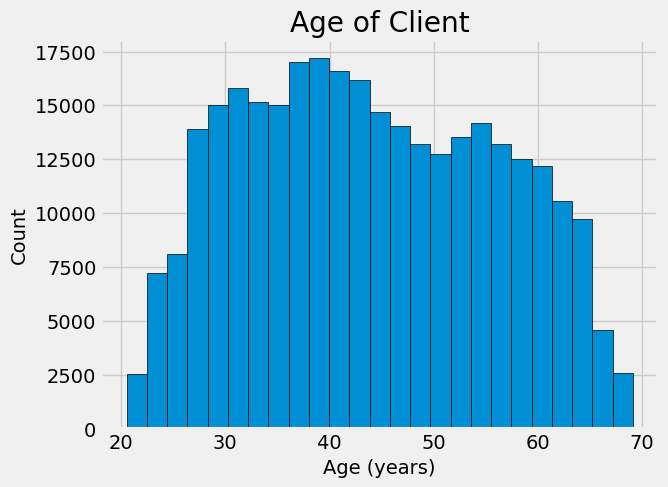

In [234]:
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

La répartition de la variable âge ne nous dit pas grand-chose, si ce n’est qu’il n’y a pas de valeurs aberrantes puisque tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite créer un [tracé d'estimation de la densité du noyau](https://www.techno-science.net/glossaire-definition/Estimation-par-noyau.html) (KDE) coloré par la valeur de la `TARGET`. Un [tracé d'estimation de la densité du noyau montre la distribution d'une seule variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement gaussien, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons `kdeplot` de seaborn pour ce graphique.

In [235]:
plt.figure(figsize = (10, 8))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.legend()
plt.xlabel('Age (années)'); 
plt.ylabel('Densité'); 
plt.title('Distribution des Ages');

La courbe TARGET == 1 est plus important sur l’extrémité gauche du graphique là ou se trouve  la population la plus jeune. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle de Machine Learning car elle affecte la `TARGET`. Examinons cette relation sous un autre angle : le non-remboursement moyen des prêts par tranche d'âge.

Pour réaliser ce graphique, nous découpons d’abord la catégorie d’âge en tranches de 5 ans chacune. Ensuite, pour chaque barplot, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque tranche d'âge.

In [236]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [237]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111442  10155.219690    27.822520
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089416  13707.908041    37.555912
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055316  20984.285455    57.491193
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

In [238]:
plt.figure(figsize = (8, 8))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
plt.xticks(rotation = 75); 
plt.xlabel('Groupe age (années)'); 
plt.ylabel('Non-remboursement (%)')
plt.title("Non-remboursement par tranche d'age");

Il y a une tendance claire : les clients les plus jeunes sont plus susceptibles de ne pas rembourser leur prêt. Le taux de non-remboursement est supérieur à 10 % pour les trois tranches d'âge les plus jeunes et inférieur à 5 % pour la tranche d'âge la plus âgée.

### Effet de la situation professionnelle sur le remboursement

In [239]:
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])

In [240]:
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_EMPLOYED'] / 365, edgecolor = 'k', bins = 25)
plt.title('Number of years worked'); 
plt.xlabel('Employed Years'); 
plt.ylabel('Count');

Pour visualiser l'effet du nombre d'années travaillées sur la cible, nous allons ensuite créer un [tracé d'estimation de la densité du noyau](https://www.techno-science.net/glossaire-definition/Estimation-par-noyau.html) (KDE) coloré par la valeur de la `TARGET`. Un [tracé d'estimation de la densité du noyau montre la distribution d'une seule variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement gaussien, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons `kdeplot` de seaborn pour ce graphique.

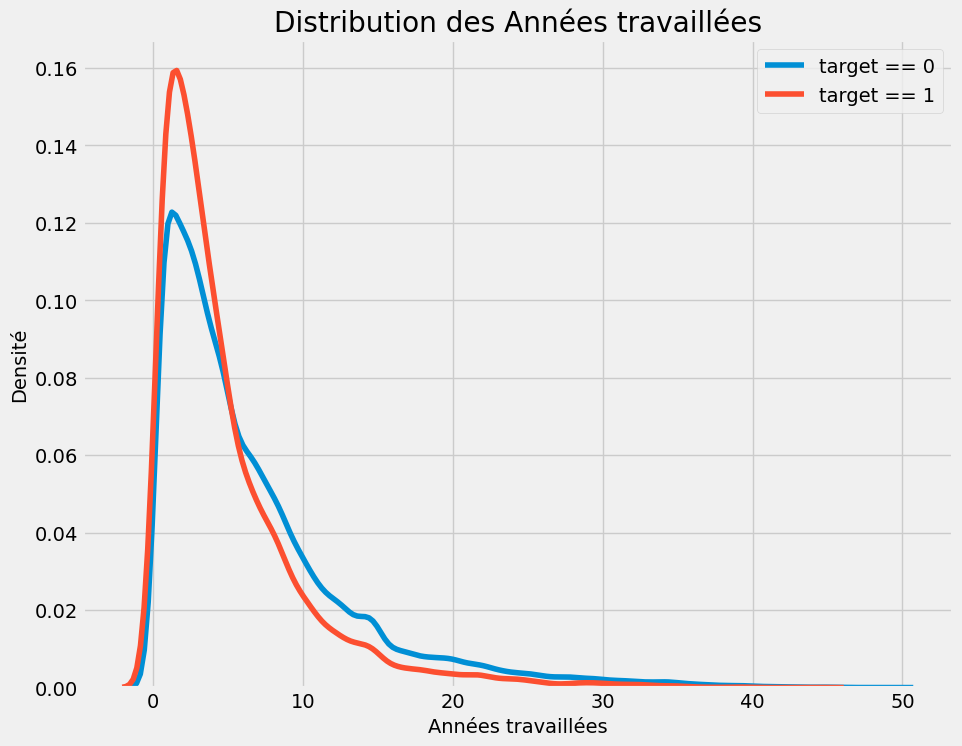

In [241]:
plt.figure(figsize = (10, 8))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, label = 'target == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, label = 'target == 1')

plt.legend()
plt.xlabel('Années travaillées'); 
plt.ylabel('Densité'); 
plt.title('Distribution des Années travaillées');

La courbe TARGET == 1 est plus important sur l’extrémité gauche du graphique là ou se trouve  ceux qui ont travaillé le moins. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle de Machine Learning car elle affecte la `TARGET`. Examinons cette relation sous un autre angle : le non-remboursement moyen des prêts par nombre d'années travaillées.

Pour réaliser ce graphique, nous découpons d’abord la catégorie nombre d'année travaillé en tranches de 5 ans chacune. Ensuite, pour chaque barplot, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque tranche d'années travaillées.

In [242]:
worked_data = app_train[['TARGET', 'DAYS_EMPLOYED']]
worked_data['YEARS_EMPLOYED'] = worked_data['DAYS_EMPLOYED'] / 365

worked_data['YEARS_BINNED'] = pd.cut(worked_data['YEARS_EMPLOYED'], bins = np.linspace(0, 50, num = 11))
worked_data.head(10)

TARGET  DAYS_EMPLOYED  YEARS_EMPLOYED YEARS_BINNED
0       1          637.0        1.745205   (0.0, 5.0]
1       0         1188.0        3.254795   (0.0, 5.0]
2       0          225.0        0.616438   (0.0, 5.0]
3       0         3039.0        8.326027  (5.0, 10.0]
4       0         3038.0        8.323288  (5.0, 10.0]
5       0         1588.0        4.350685   (0.0, 5.0]
6       0         3130.0        8.575342  (5.0, 10.0]
7       0          449.0        1.230137   (0.0, 5.0]
8       0            NaN             NaN          NaN
9       0         2019.0        5.531507  (5.0, 10.0]

In [243]:
worked_groups  = worked_data.groupby('YEARS_BINNED').mean()
worked_groups

TARGET  DAYS_EMPLOYED  YEARS_EMPLOYED
YEARS_BINNED                                         
(0.0, 5.0]    0.105709     864.338095        2.368050
(5.0, 10.0]   0.073717    2630.227316        7.206102
(10.0, 15.0]  0.057752    4466.899670       12.238081
(15.0, 20.0]  0.048484    6306.860448       17.279070
(20.0, 25.0]  0.047573    8092.875701       22.172262
(25.0, 30.0]  0.039915    9961.412156       27.291540
(30.0, 35.0]  0.041258   11791.751418       32.306168
(35.0, 40.0]  0.019231   13517.634615       37.034615
(40.0, 45.0]  0.004762   15325.461905       41.987567
(45.0, 50.0]  0.000000   16862.916667       46.199772

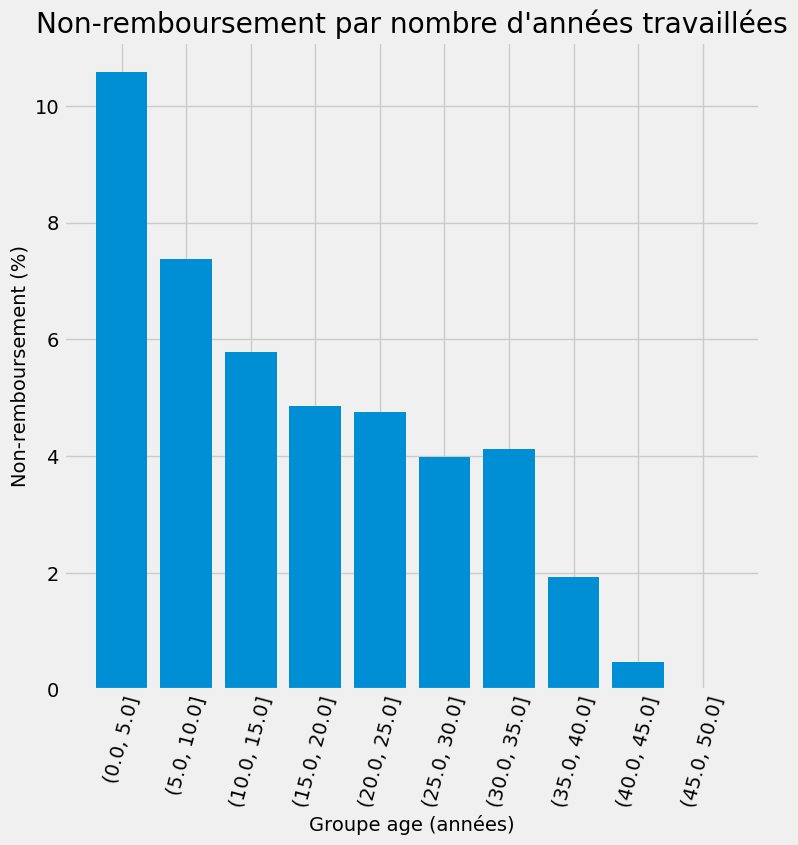

In [244]:
plt.figure(figsize = (8, 8))

plt.bar(worked_groups.index.astype(str), 100 * worked_groups['TARGET'])
plt.xticks(rotation = 75); 
plt.xlabel('Groupe age (années)'); 
plt.ylabel('Non-remboursement (%)')
plt.title("Non-remboursement par nombre d'années travaillées");

Il y a une tendance claire : les clients ayant le moins ou pas travaillé sont plus susceptibles de ne pas rembourser leur prêt. Le taux de non-remboursement est supérieur à 10 % pour la première tranche alors qu'elle passe à moins de 6% pour ceux ayant déjà travaillé plus de 10 ans.

Cette observation peut directement être rattaché à notre précédente observation concernant les plus jeune ayant des difficultés à rembourser leur prêt. En effet les plus jeune sont ceux étant les plus susceptible à ne pas avoir beaucoup travaillé.

Il s’agit d’informations qui pourraient être directement utilisées par la banque : étant donné que les clients plus jeunes sont moins susceptibles de rembourser le prêt, il faudrait peut-être leur fournir davantage de conseils en matière de planification financière. Cela ne signifie pas que la banque doit faire preuve de discrimination à l'égard des clients plus jeunes, mais il serait judicieux de prendre des mesures de précaution pour aider les jeunes clients à payer à temps.

### EXT_SOURCE
Les 3 variables avec les corrélations négatives les plus fortes avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2` et `EXT_SOURCE_3`.
Selon la documentation, ces fonctionnalités représentent un "score normalisé provenant d'une source de données externe". Je ne suis pas sûr de ce que cela signifie exactement, mais il peut s'agir d'une sorte de notation de crédit cumulative établie à l'aide de nombreuses sources de données.

Analysons ces variables.

Tout d'abord, nous pouvons montrer les corrélations des variable `EXT_SOURCE` avec la `TARGET` et entre elles.

In [245]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2',\
                      'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]
ext_data_corrs = ext_data.corr(method='spearman')
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  \
TARGET         1.000000     -0.151129     -0.147331     -0.166336   -0.078331   
EXT_SOURCE_1  -0.151129      1.000000      0.220776      0.181127    0.600190   
EXT_SOURCE_2  -0.147331      0.220776      1.000000      0.106196    0.102173   
EXT_SOURCE_3  -0.166336      0.181127      0.106196      1.000000    0.205196   
DAYS_BIRTH    -0.078331      0.600190      0.102173      0.205196    1.000000   
DAYS_EMPLOYED -0.080269      0.232741      0.109760      0.135501    0.307443   

               DAYS_EMPLOYED  
TARGET             -0.080269  
EXT_SOURCE_1        0.232741  
EXT_SOURCE_2        0.109760  
EXT_SOURCE_3        0.135501  
DAYS_BIRTH          0.307443  
DAYS_EMPLOYED       1.000000

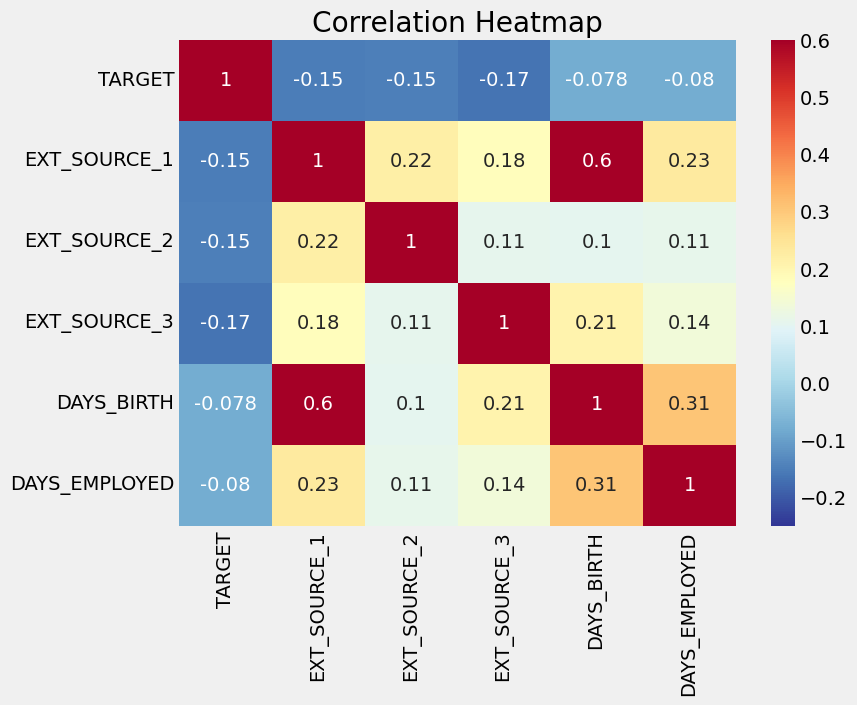

In [246]:
plt.figure(figsize = (8, 6))

sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Nous pouvons immédiatement remarquer la corrélation mis en avant précédemment entre `DAYS_EMPLOYED` et `DAYS_BIRTH`. En effet les plus jeune sont ceux les plus susceptible à avoir le moins travaillé. Egalement il semble y avoir une relation linéaire positive modérée entre `EXT_SOURCE_1` et `DAYS_BIRTH` (ou de manière équivalente `YEARS_BIRTH`), indiquant que cette features peut prendre en compte l'âge du client.
Les trois variables `EXT_SOURCE` ont des corrélations négatives avec la `TARGET`, ce qui indique qu'à mesure que la valeur de `EXT_SOURCE` augmente, le client est plus susceptible de rembourser le prêt. Nous pouvons également voir que `DAYS_BIRTH` est positivement corrélé avec `EXT_SOURCE_1`, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Nous pouvons ensuite examiner la distribution de chacune de ces variable colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la `TARGET`.

In [247]:
plt.figure(figsize = (10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # créer une nouveau graph pour chaque variable
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    plt.legend()

    plt.title('Distribution de %s par rapport à la TARGET' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité');
    
plt.tight_layout(h_pad = 2.5)

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la `TARGET`. Nous pouvons clairement voir que cette variable a un certain lien avec la probabilité qu'un demandeur rembourse un prêt. La corrélation n'est pas très forte (en fait elles sont toutes [considérées comme très faibles](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf)), mais ces variables seront quand même utiles pour un modèle de Machine Learning pour prédire si un demandeur remboursera ou non un prêt à temps.

# Ingénierie des fonctionnalités
L'ingénierie des fonctionnalités fait référence à un processus général et peut impliquer à la fois la construction de fonctionnalités : l'ajout de nouvelles fonctionnalités à partir des données existantes, et la sélection de fonctionnalités : choisir uniquement les fonctionnalités les plus importantes ou d'autres méthodes de réduction de dimensionnalité. Il existe de nombreuses techniques que nous pouvons utiliser pour créer et sélectionner des fonctionnalités.

Nous ferons beaucoup d'ingénierie de fonctionnalités lorsque nous commencerons à utiliser les autres sources de données, mais dans ce Notebook, nous essaierons uniquement deux méthodes simples de construction de fonctionnalités :

* Caractéristiques polynomiales
* Analyse métier

## Caractéristiques polynomiales
Une méthode simple de construction de fonctionnalités est appelée [fonctionnalités polynomiales] (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). Dans cette méthode, nous créons des features qui sont des puissances de features existantes ainsi que des termes d'interaction entre features existantes. Par exemple, nous pouvons créer des variables `EXT_SOURCE_1^2` et `EXT_SOURCE_2^2` ainsi que des variables telles que `EXT_SOURCE_1` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2^2`, `EXT_SOURCE_1^2` x `EXT_SOURCE_2^ 2`, et ainsi de suite. Ces fonctionnalités qui sont une combinaison de plusieurs variables individuelles sont appelées [interaction](https://fr.wikipedia.org/wiki/Interaction_(statistiques)#:~:text=Le%20terme%20%22interaction%22%20est%20donc,contexte%20des%20analyses%20de%20r%C3%A9gression.) car elles capturent les interactions entre les variables. En d'autres termes, lorsque deux variables par elles-mêmes n'ont pas d'influence sur la cible, les combiner en une seule variable d'interaction pourrait montrer une relation avec la cible. [Les interaction sont couramment utilisés dans les modèles statistiques] (https://www.theanalysisfactor.com/interpreting-interactions-in-regression/) pour capturer les effets de plusieurs variables, nous pouvons en essayer quelques-unes pour voir si elles pourraient aider notre modèle à prédire si un client remboursera un prêt.

Jake VanderPlas écrit sur les [fonctionnalités polynomiales dans son excellent livre Python for Data Science](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html) pour ceux qui souhaitent plus d'informations.

Dans le code suivant, nous créons des fonctionnalités polynomiales en utilisant les variables `EXT_SOURCE` et la variable `DAYS_BIRTH`. [Scikit-Learn a une classe utile appelée `PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) qui crée les polynômes et les interaction jusqu'à une valeur spécifiée. Nous pouvons utiliser un degré de 3 pour voir les résultats (lorsque nous créons des entités polynomiales, nous voulons éviter d'utiliser un degré trop élevé, à la fois parce que le nombre d'entités évolue de façon exponentielle avec le degré, et parce que nous pouvons rencontrer des [problèmes d'overfitting](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)).

In [248]:
# on crée de nouveau Dataframe pour stocker nos fonctionnalités polynomiales
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# on utilise un imputer pour remplacer les valeurs manquantes par la médiane
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# on remplace les valeurs manquantes
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# on crée un objet polynomiale en spécifiant le degré
poly_transformer = PolynomialFeatures(degree = 3)

In [249]:
# On entraine notre fonctionnalité polynomiale
poly_transformer.fit(poly_features)

# on transforme nos variables
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307507, 35)


Cela crée un nombre considérable de nouvelles features. Pour obtenir les noms, nous devons utiliser la méthode `get_feature_names_out`.

In [250]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1',\
                                                         'EXT_SOURCE_2', 'EXT_SOURCE_3',\
                                                         'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

Il existe 35 nouvelles variables dont certaines allant jusqu'a 3 degrés d'interaction. Nous pouvons désormais voir si l’une de ces nouvelles features est plus corrélée à la `TARGET`.

In [251]:
# Créer un dataframe avec ces nouvelles variables 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1',\
                                                                               'EXT_SOURCE_2',\
                                                                               'EXT_SOURCE_3',\
                                                                               'DAYS_BIRTH']))

# On rajoute la cible dans le dataframe que l'on avait retiré auparavant
poly_features['TARGET'] = poly_target

# On cherche les corrélation avec la cible
poly_corrs = poly_features.corr(method="spearman")['TARGET'].sort_values()

# On affiche les meilleures corrélations positive et négative
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.027058
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.025444
EXT_SOURCE_2 EXT_SOURCE_3                -0.025440
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.025192
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.024016
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.023146
EXT_SOURCE_1 EXT_SOURCE_2                -0.022897
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH     -0.022459
EXT_SOURCE_1^2 EXT_SOURCE_2              -0.021886
EXT_SOURCE_2^2 DAYS_BIRTH                -0.021807
Name: TARGET, dtype: float64
DAYS_BIRTH^2   -0.01029
DAYS_BIRTH     -0.01029
DAYS_BIRTH^3   -0.01029
TARGET          1.00000
1                   NaN
Name: TARGET, dtype: float64


La corrélation entre ces nouvelles variables et la `TARGET` n'est clairement pas explicite. De plus mes tests préliminaires de sélection de variable pour un modèle de Machine Learning ne m'ont pas permis de garder ces features comme caractéristique intéressantes pour notre problématique.

## Analyse métier
Nous pouvons élaborer quelques caractéristiques qui tentent de saisir ce que nous pensons être important pour déterminer si un client ne rembourse pas son prêt. Ici, je vais utiliser cinq fonctionnalités inspirées de [ce script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) d'Aguiar :

* `CREDIT_INCOME_PERCENT` : le pourcentage du montant du crédit par rapport aux revenus d'un client
* `ANNUITY_INCOME_PERCENT` : le pourcentage de la rente du prêt par rapport au revenu d'un client
* `CREDIT_TERM` : la durée du paiement en mois (puisque la rente est le montant mensuel dû)
* `DAYS_EMPLOYED_PERCENT` : le pourcentage de jours employés par rapport à l'âge du client

In [252]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

#### Visualisation des nouvelles variables
Nous devrions explorer visuellement ces variables analyse métier dans un graphique. Pour tout cela, nous créerons le même tracé KDE coloré par la valeur de `TARGET`.

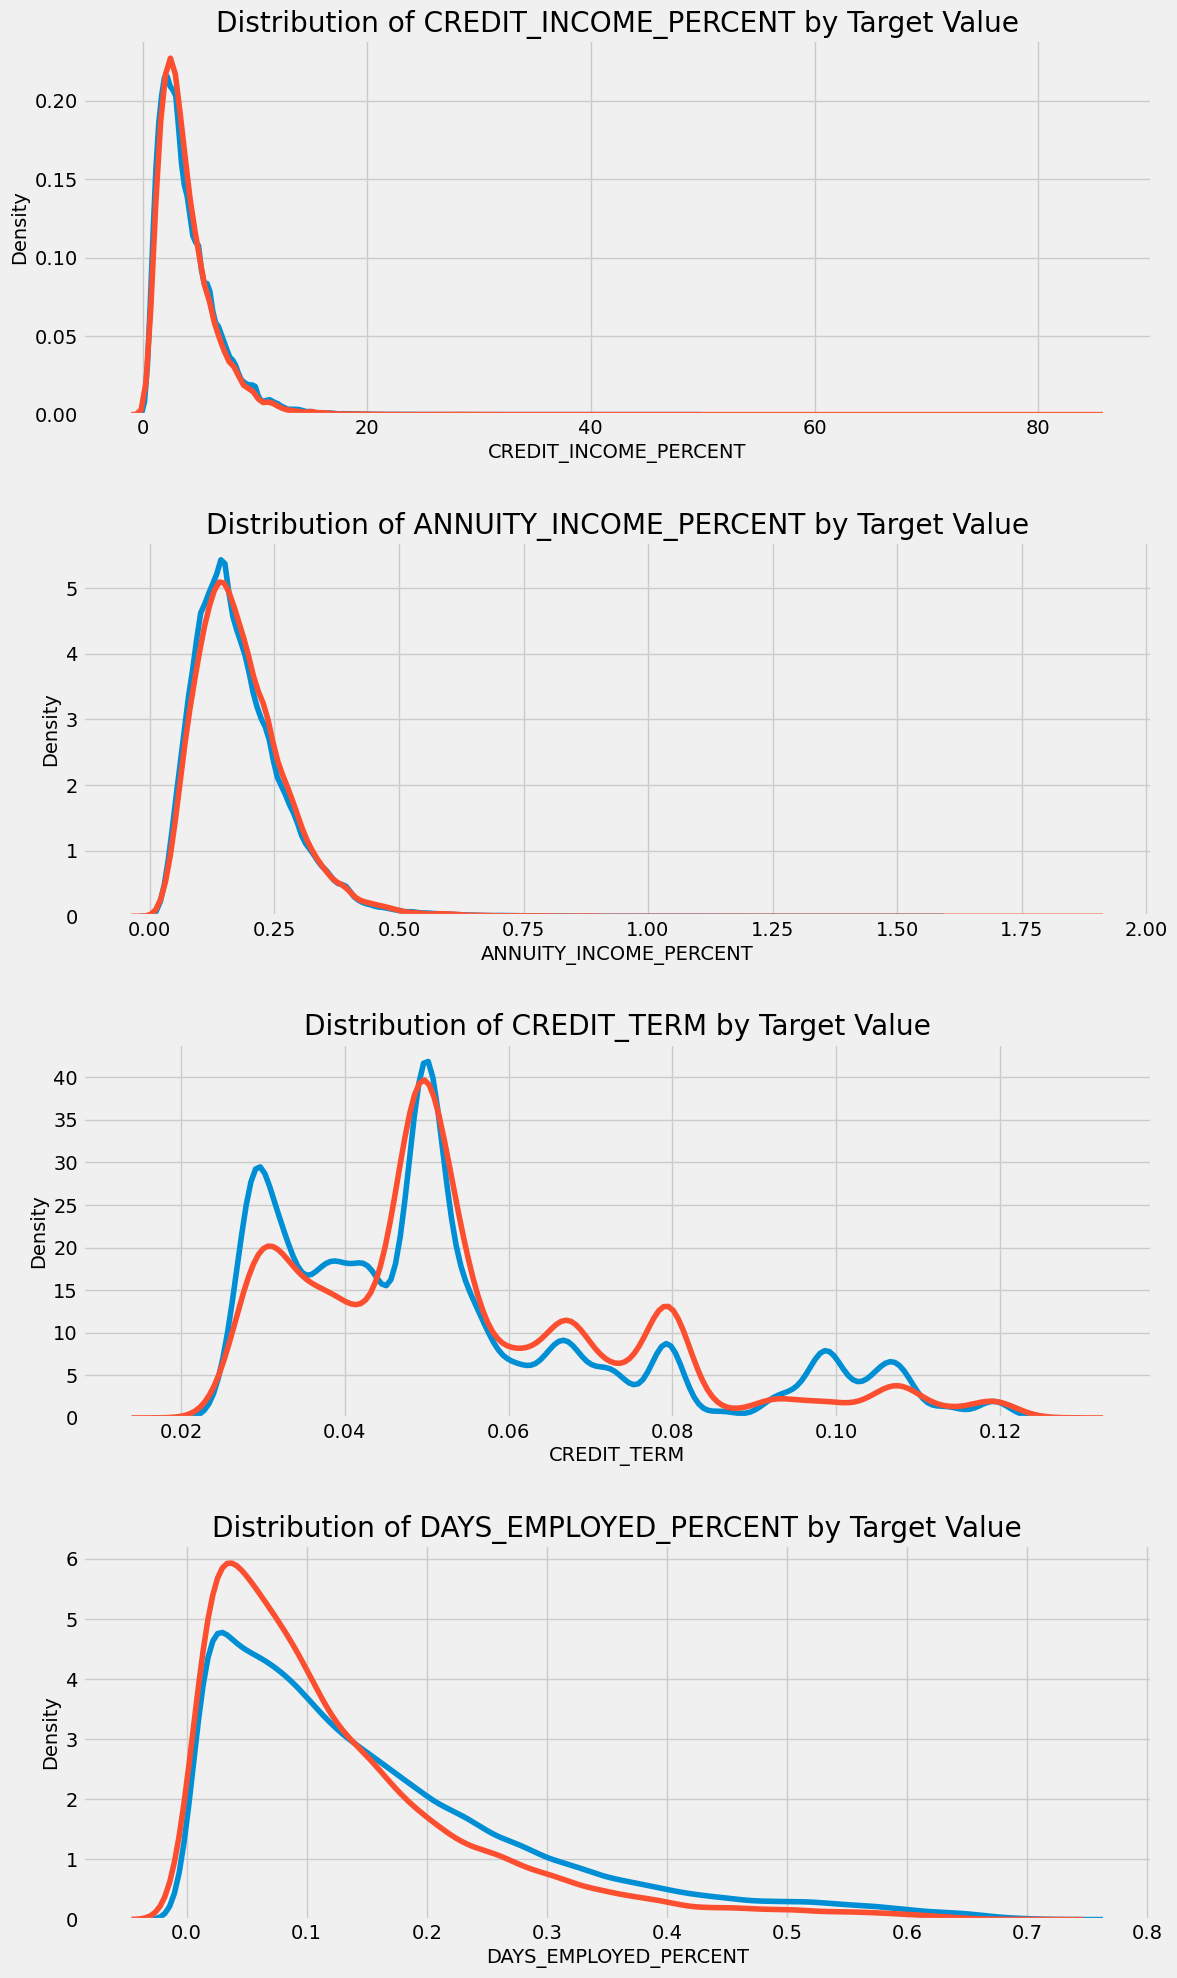

In [253]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Difficile de dire à l’avance si ces nouvelles variables seront utiles. La seule façon d’en être sûr est de les essayer.

In [254]:
domain_data = app_train_domain[['TARGET', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT',\
                      'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']]
domain_data_corrs = domain_data.corr(method='spearman')
domain_data_corrs

TARGET  CREDIT_INCOME_PERCENT  \
TARGET                  1.000000              -0.001801   
CREDIT_INCOME_PERCENT  -0.001801               1.000000   
ANNUITY_INCOME_PERCENT  0.018428               0.793888   
CREDIT_TERM             0.030265              -0.635144   
DAYS_EMPLOYED_PERCENT  -0.067899               0.035737   

                        ANNUITY_INCOME_PERCENT  CREDIT_TERM  \
TARGET                                0.018428     0.030265   
CREDIT_INCOME_PERCENT                 0.793888    -0.635144   
ANNUITY_INCOME_PERCENT                1.000000    -0.078800   
CREDIT_TERM                          -0.078800     1.000000   
DAYS_EMPLOYED_PERCENT                 0.009543    -0.047475   

                        DAYS_EMPLOYED_PERCENT  
TARGET                              -0.067899  
CREDIT_INCOME_PERCENT                0.035737  
ANNUITY_INCOME_PERCENT               0.009543  
CREDIT_TERM                         -0.047475  
DAYS_EMPLOYED_PERCENT                1.000000

## Data Preprocessing
Notre Dataset dispose de trop nombreuses variable pour pouvoir créer un modèle efficient. Pour faciliter le travail de Machine Learning, nous devons selectionner les variables pertinente et supprimer celle qui n'ont pas d'impact dans la modélisation de notre problématique.
Nous commençons par supprimer les variables continues qui sont indépendantes de `TARGET` en réalisant un test de Kruskal Willis car la distribution des variables n'est pas normale et n'est pas homoscédastique.

In [255]:
import pandas as pd
from scipy.stats import kruskal


# Séparer la variable cible et les variables indépendantes
target = app_train['TARGET']
independent_vars = app_train[non_categorial_columns]

# Créer un DataFrame pour stocker les résultats
results = pd.DataFrame(columns=['Variable', 'Kruskal-Wallis p-value'])

# Parcourir toutes les variables indépendantes
for col in independent_vars.columns:
    # Effectuer le test de Kruskal-Wallis
    stat, p_value = kruskal(*[group[col] for group_name,\
                              group in independent_vars.groupby(target)])
    
    # Ajouter les résultats au DataFrame
    results = results.append({'Variable': col, 'Kruskal-Wallis p-value': p_value},\
                             ignore_index=True)

# Afficher les variables indépendantes (p-value > seuil de signification)
significance_level = 0.05
independent_variables = results[results['Kruskal-Wallis p-value'] > significance_level]
print("Variables indépendantes par rapport à TARGET :")
print(independent_variables)

Variables indépendantes par rapport à TARGET :
     Variable  Kruskal-Wallis p-value
0  SK_ID_CURR                0.241121


Puis pour les variables discrètes nous pouvons effectuer un test Chi2 pour éliminer les variables qui ne sont pas corrélées avec la `TARGET`

In [256]:
import pandas as pd
from scipy.stats import chi2_contingency

target = app_train['TARGET']
independent_vars = app_train[categorial_columns]
results = pd.DataFrame(columns=['Variable', 'Chi2 p-value'])

for col in independent_vars.columns:
    contingency_table = pd.crosstab(target, independent_vars[col])
    stat, p_value, _, _ = chi2_contingency(contingency_table)
    
    results = results.append({'Variable': col, 'Chi2 p-value': p_value}, ignore_index=True)

significance_level = 0.05
independent_variables = results[results['Chi2 p-value'] > significance_level]
print("Variables indépendantes par rapport à TARGET :")
print(independent_variables)


Variables indépendantes par rapport à TARGET :
                                Variable  Chi2 p-value
5                             FLAG_MOBIL      1.000000
8                       FLAG_CONT_MOBILE      0.897626
10                            FLAG_EMAIL      0.336402
13           LIVE_REGION_NOT_WORK_REGION      0.122033
17                        APARTMENTS_AVG      0.994044
..                                   ...           ...
190  ORGANIZATION_TYPE_Transport: type 2      0.670109
195     FONDKAPREMONT_MODE_not specified      0.145706
201        HOUSETYPE_MODE_terraced house      0.622832
203             WALLSMATERIAL_MODE_Mixed      0.361948
205            WALLSMATERIAL_MODE_Others      0.762214

[90 rows x 2 columns]


In [257]:
app_train_sampled = app_train.copy()

for i in independent_variables['Variable']:
    app_train_sampled.drop(columns=[i], inplace=True)
    
app_train_sampled.drop(columns=['SK_ID_CURR'], inplace=True)
app_train_sampled

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0            1                   0            1             0   
1            0                   0            0             0   
2            0                   1            1             1   
3            0                   0            0             0   
4            0                   0            1             0   
...        ...                 ...          ...           ...   
307506       0                   0            1             0   
307507       0                   0            0             0   
307508       0                   0            0             0   
307509       1                   0            0             0   
307510       0                   0            0             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     1             0          202500.0    406597.5   
1                     0             0          270000.0   1293502.5   
2                     1             0           67500.0    135000.0   
3                     1             0          135000.0    312682.5   
4                     1             0          121500.0    513000.0   
...                 ...           ...               ...         ...   
307506                0             0          157500.0    254700.0   
307507                1             0           72000.0    269550.0   
307508                1             0          153000.0    677664.0   
307509                1             0          171000.0    370107.0   
307510                0             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  ...  HOUSETYPE_MODE_block of flats  \
0           24700.5         351000.0  ...                              1   
1           35698.5        1129500.0  ...                              1   
2            6750.0         135000.0  ...                              0   
3           29686.5         297000.0  ...                              0   
4           21865.5         513000.0  ...                              0   
...             ...              ...  ...                            ...   
307506      27558.0         225000.0  ...                              1   
307507      12001.5         225000.0  ...                              1   
307508      29979.0         585000.0  ...                              1   
307509      20205.0         319500.0  ...                              1   
307510      49117.5         675000.0  ...                              1   

        HOUSETYPE_MODE_specific housing  WALLSMATERIAL_MODE_Block  \
0                                     0                         0   
1                                     0                         1   
2                                     0                         0   
3                                     0                         0   
4                                     0                         0   
...                                 ...                       ...   
307506                                0                         0   
307507                                0                         0   
307508                                0                         0   
307509                                0                         0   
307510                                0                         0   

        WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Panel  \
0                                   0                         0   
1                                   0                         0   
2                                   0                         0   
3                                   0                         0   
4                                   0                         0   
...                               ...                       ...   
307506                              0                         0   
307507                              0                         0   
307508                       

Après avoir supprimé les variables peu corrélés à la `TARGET` nous supprimons les variables fortement corrélés entres elles. Nous supprimons ensuite l'une des deux variables pour n'en conserver qu'une seul. Nous admettons un coefficient minimal de corrélation de 0.7 ce qui correspond à une forte corrélation entre deux variables. Ce travail nous permet de diminuer fortement la taille de nos features.

In [258]:
correlation_matrix = app_train_sampled.corr().abs()
correlation_matrix

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
TARGET                           1.000000            0.030886     0.054710   
NAME_CONTRACT_TYPE               0.030886            1.000000     0.008755   
CODE_GENDER                      0.054710            0.008755     1.000000   
FLAG_OWN_CAR                     0.021850            0.004009     0.345848   
FLAG_OWN_REALTY                  0.006146            0.067155     0.044374   
...                                   ...                 ...          ...   
WALLSMATERIAL_MODE_Stone, brick  0.012654            0.015070     0.020716   
WALLSMATERIAL_MODE_Wooden        0.007946            0.000045     0.006648   
EMERGENCYSTATE_MODE_No           0.042200            0.027355     0.029356   
EMERGENCYSTATE_MODE_Yes          0.004829            0.000336     0.005170   
DAYS_EMPLOYED_ANOM               0.045989            0.054952     0.157310   

                                 FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
TARGET                               0.021850         0.006146      0.019189   
NAME_CONTRACT_TYPE                   0.004009         0.067155      0.029981   
CODE_GENDER                          0.345848         0.044374      0.047387   
FLAG_OWN_CAR                         1.000000         0.002820      0.102037   
FLAG_OWN_REALTY                      0.002820         1.000000      0.002370   
...                                       ...              ...           ...   
WALLSMATERIAL_MODE_Stone, brick      0.025587         0.017440      0.025099   
WALLSMATERIAL_MODE_Wooden            0.009211         0.014576      0.011037   
EMERGENCYSTATE_MODE_No               0.034749         0.022009      0.038654   
EMERGENCYSTATE_MODE_Yes              0.007584         0.008534      0.004526   
DAYS_EMPLOYED_ANOM                   0.154778         0.070111      0.240722   

                                 AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
TARGET                                   0.003982    0.030371     0.012818   
NAME_CONTRACT_TYPE                       0.003534    0.221643     0.241540   
CODE_GENDER                              0.074730    0.021597     0.076990   
FLAG_OWN_CAR                             0.083381    0.116226     0.141589   
FLAG_OWN_REALTY                          0.002934    0.039266     0.005221   
...                                           ...         ...          ...   
WALLSMATERIAL_MODE_Stone, brick          0.016522    0.009761     0.009193   
WALLSMATERIAL_MODE_Wooden                0.003368    0.007374     0.007712   
EMERGENCYSTATE_MODE_No                   0.050175    0.058259     0.068149   
EMERGENCYSTATE_MODE_Yes                  0.002894    0.004308     0.003911   
DAYS_EMPLOYED_ANOM                       0.064038    0.065598     0.103612   

                                 AMT_GOODS_PRICE  ...  \
TARGET                                  0.039647  ...   
NAME_CONTRACT_TYPE                      0.185850  ...   
CODE_GENDER                             0.022512  ...   
FLAG_OWN_CAR                            0.120306  ...   
FLAG_OWN_REALTY                         0.045535  ...   
...                                          ...  ...   
WALLSMATERIAL_MODE_Stone, brick         0.012885  ...   
WALLSMATERIAL_MODE_Wooden               0.009136  ...   
EMERGENCYSTATE_MODE_No                  0.062879  ...   
EMERGENCYSTATE_MODE_Yes                 0.004848  ...   
DAYS_EMPLOYED_ANOM                      0.063571  ...   

                                 HOUSETYPE_MODE_block of flats  \
TARGET                                                0.040592   
NAME_CONTRACT_TYPE                                    0.027114   
CODE_GENDER                                           0.026651   
FLAG_OWN_CAR                                          0.031665   
FLAG_OWN_REALTY                                       0.022846   
...                                                        ...   
WALLSMATERIAL_MODE_Stone, brick                      

In [259]:
threshold = 0.7
corr_var_pairs = np.where(correlation_matrix > threshold)

In [260]:
variables_to_drop = set()

for i, j in zip(*corr_var_pairs):
    if i != j and i not in variables_to_drop and j not in variables_to_drop:
        variable_to_drop = app_train_sampled.columns[j]
        variables_to_drop.add(variable_to_drop)

app_train_sampled = app_train_sampled.drop(columns=variables_to_drop)
app_train_sampled

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0            1                   0            1             0   
1            0                   0            0             0   
2            0                   1            1             1   
3            0                   0            0             0   
4            0                   0            1             0   
...        ...                 ...          ...           ...   
307506       0                   0            1             0   
307507       0                   0            0             0   
307508       0                   0            0             0   
307509       1                   0            0             0   
307510       0                   0            0             0   

        FLAG_OWN_REALTY  AMT_INCOME_TOTAL  REGION_POPULATION_RELATIVE  \
0                     1          202500.0                    0.018801   
1                     0          270000.0                    0.003541   
2                     1           67500.0                    0.010032   
3                     1          135000.0                    0.008019   
4                     1          121500.0                    0.028663   
...                 ...               ...                         ...   
307506                0          157500.0                    0.032561   
307507                1           72000.0                    0.025164   
307508                1          153000.0                    0.005002   
307509                1          171000.0                    0.005313   
307510                0          157500.0                    0.046220   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  \
0             9461          637.0            -3648.0  ...   
1            16765         1188.0            -1186.0  ...   
2            19046          225.0            -4260.0  ...   
3            19005         3039.0            -9833.0  ...   
4            19932         3038.0            -4311.0  ...   
...            ...            ...                ...  ...   
307506        9327          236.0            -8456.0  ...   
307507       20775            NaN            -4388.0  ...   
307508       14966         7921.0            -6737.0  ...   
307509       11961         4786.0            -2562.0  ...   
307510       16856         1262.0            -5128.0  ...   

        FONDKAPREMONT_MODE_org spec account  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
307506                                    0   
307507                                    0   
307508                                    0   
307509                                    0   
307510                                    0   

        FONDKAPREMONT_MODE_reg oper account  \
0                                         1   
1                                         1   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
307506                                    1   
307507                                    1   
307508                                    1   
307509                                    0   
307510                                    0   

        FONDKAPREMONT_MODE_reg oper spec account  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
307506                                         0   
307507                                         0   
307508             

Nous recherchons ensuite les variables qui ont des valeurs manquantes

In [261]:
Nan_values = app_train_sampled.isnull().sum()
total_values = len(app_train_sampled)
Nan_values_percentage = (Nan_values / total_values) * 100
Nan_values_percentage = round(Nan_values_percentage, 2)

In [262]:
high_missing = Nan_values_percentage[Nan_values_percentage > 20]\
.index.tolist()
high_missing

['OWN_CAR_AGE', 'EXT_SOURCE_1', 'NONLIVINGAPARTMENTS_MODE']

Ces deux variables ont une faible corrélation avec la `TARGET` ou sont fortement corrélé à une autre variable comme nous avons pu le voir précédemment avec `EXT_SOURCE_1` corrélé à `DAY_BIRTH`

In [263]:
high_missing_corrs = app_train_sampled[high_missing].corrwith(\
                                        app_train_sampled['TARGET'],method="spearman")
high_missing_corrs

OWN_CAR_AGE                 0.052932
EXT_SOURCE_1               -0.151129
NONLIVINGAPARTMENTS_MODE   -0.003666
dtype: float64

In [264]:
app_train_sampled = app_train_sampled.drop(columns=['OWN_CAR_AGE'])
app_train_sampled = app_train_sampled.drop(columns=['EXT_SOURCE_1'])
app_train_sampled = app_train_sampled.drop(columns=['NONLIVINGAPARTMENTS_MODE'])

Pour les données manquantes de la variable `DAYS_EMPLOYED` nous pouvons les remplacer par 0 car ces données manquantes sont probablement liées au fait que les individus non jamais travaillé.

In [265]:
app_train_sampled['DAYS_EMPLOYED'].fillna(0, inplace=True)

Pour éviter d'ajouter un biais inutile à notre modèle, il est plus simple d'éliminer la faible part d'individus qui disposent encore de données manquantes dans certaines variables importantes.

In [266]:
index_drop = app_train_sampled[app_train_sampled['EXT_SOURCE_3'].isna()].index
app_train_sampled.drop(index_drop, inplace=True)
index_drop = app_train_sampled[app_train_sampled['EXT_SOURCE_2'].isna()].index
app_train_sampled.drop(index_drop, inplace=True)

<Axes: >

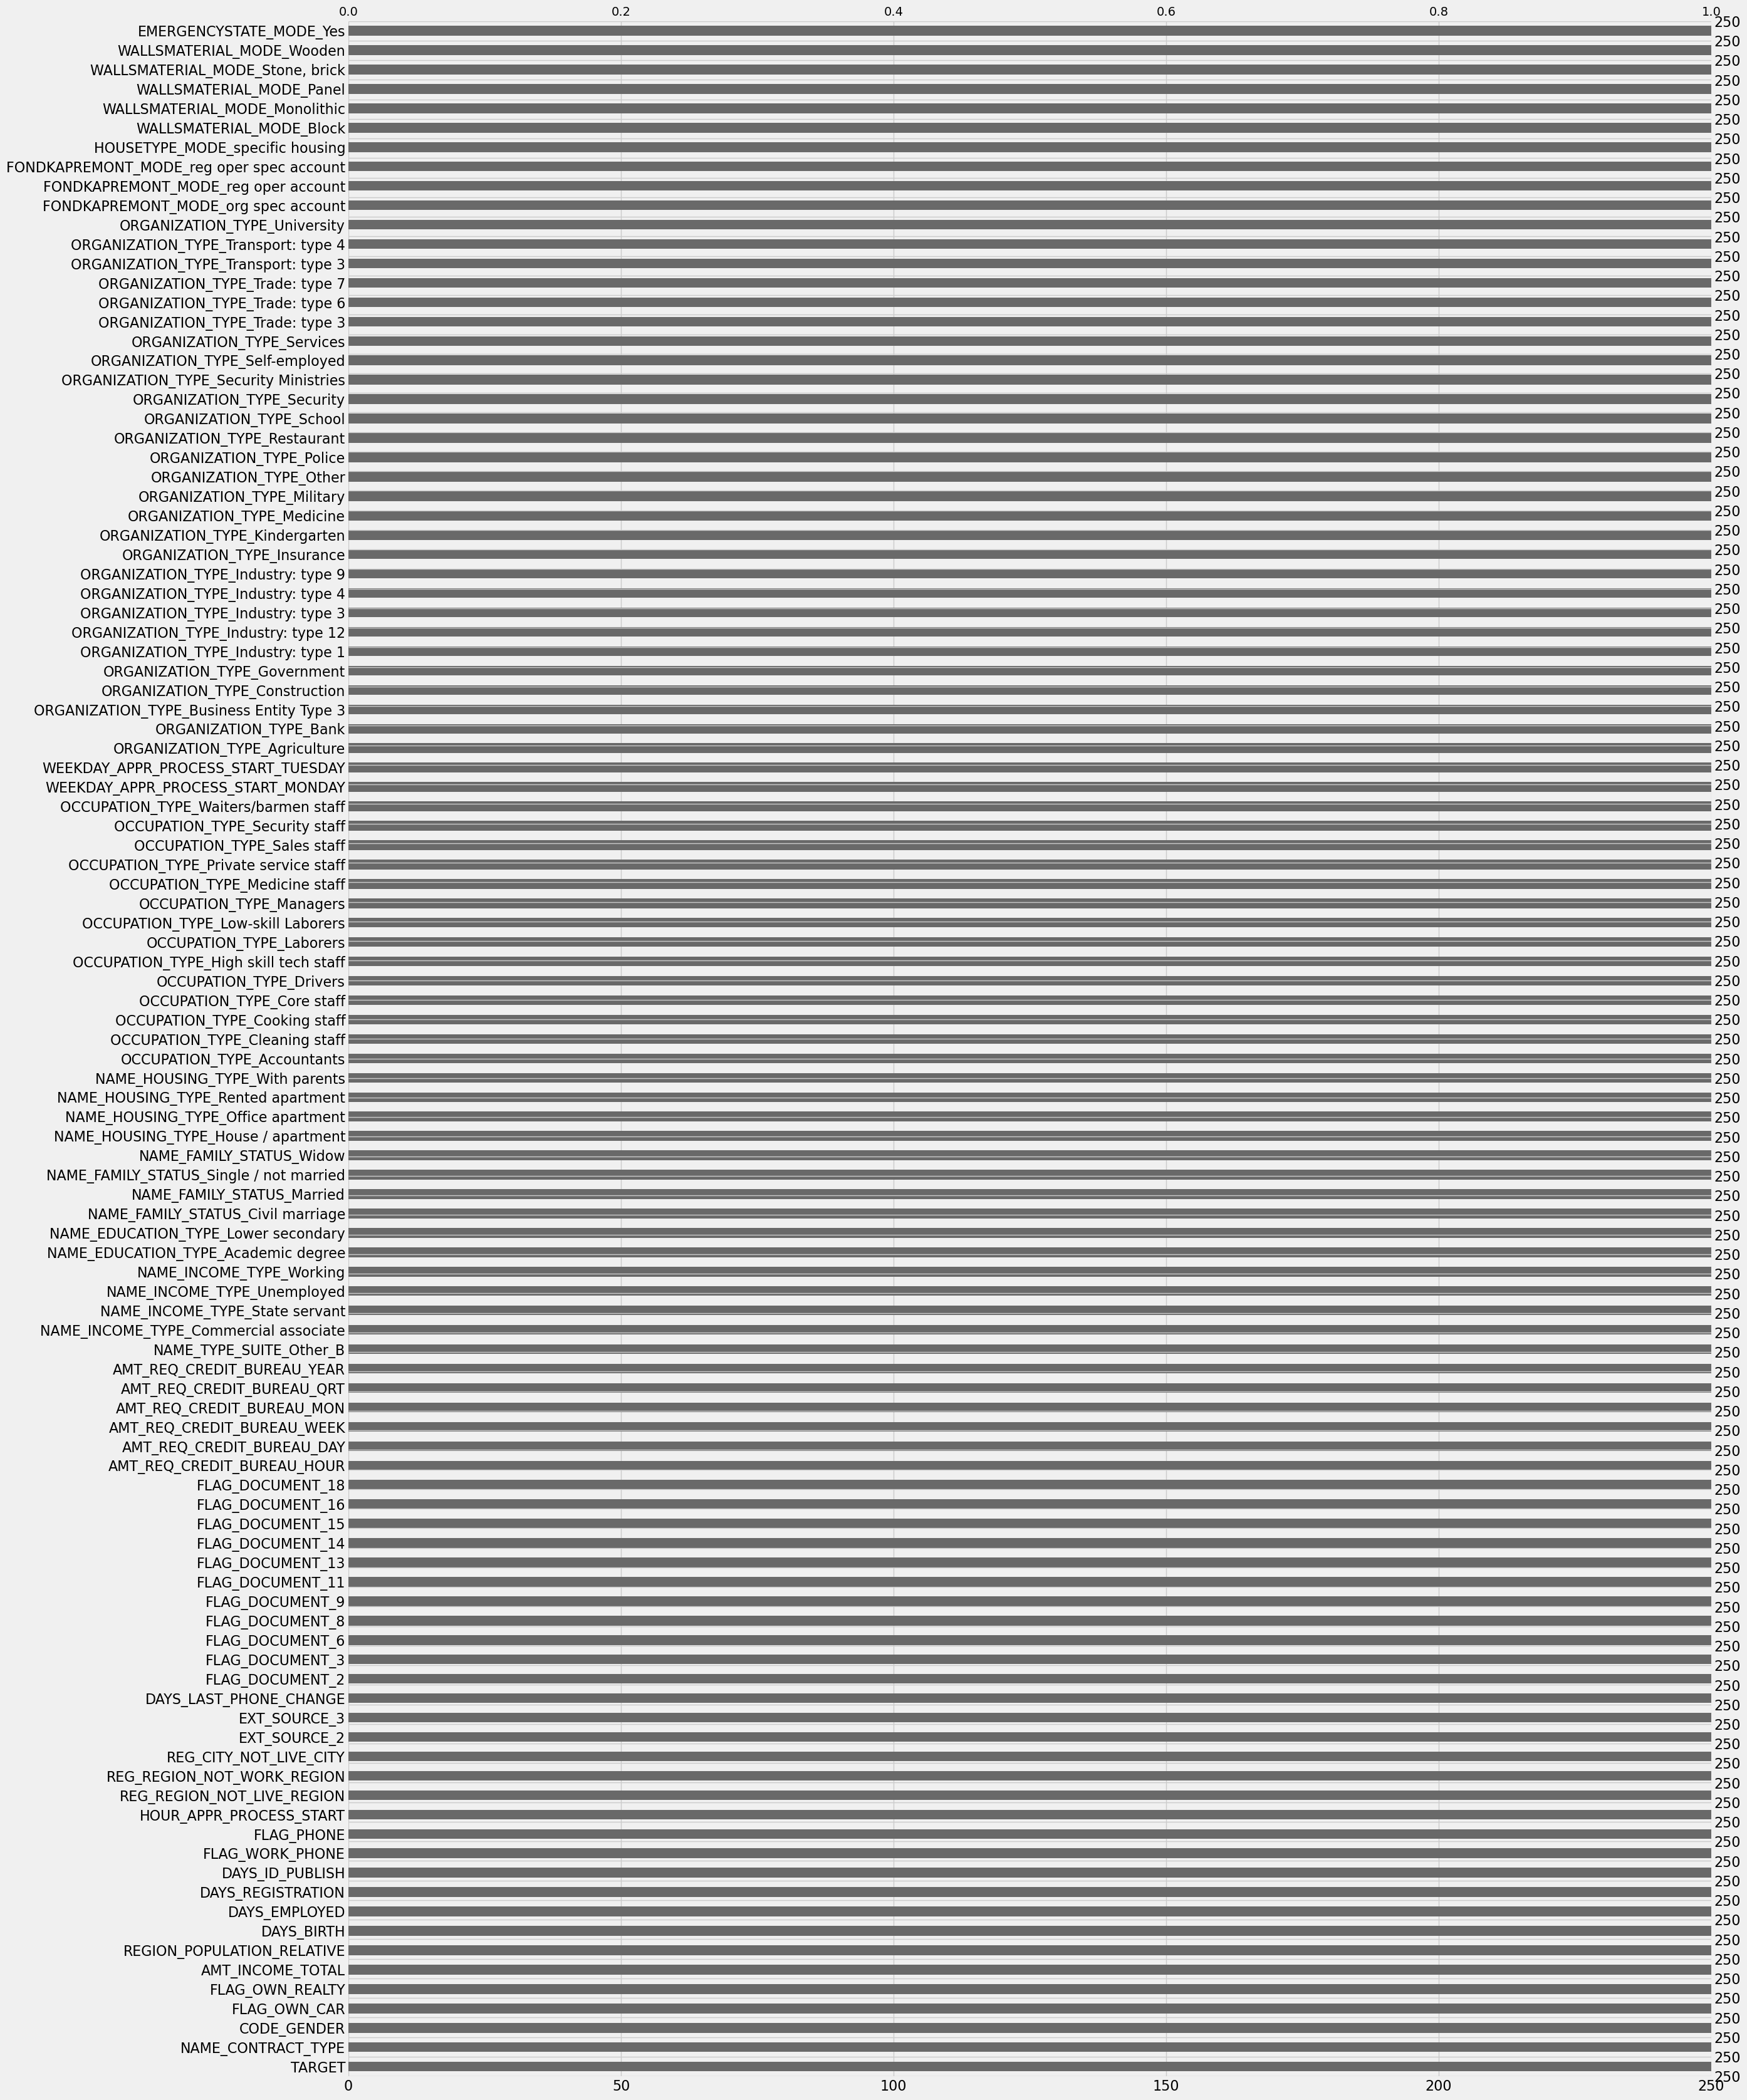

In [267]:
msno.bar(app_train_sampled.sample(250))

## Echantillonnage
Certain modèle de machine learning ont un temps de traitement extrêment long, nous avons donc décidé d'effectuer un échantillonnage de nos données pour accélérer le temps de traitement.

In [268]:
app_train_sampled = app_train_sampled.sample(50000, replace=False)
app_train_sampled.shape

(50000, 106)

## Séparation des données
Pour éviter le Data-Leakage de nos données qui pourrait influencer le modèle de Machine Learning nous effectuons une opération de séparation des données puis une opération de resampling uniquement sur les données d'entrainements car cette étape crée de nouvelles variables synthétique à partir de celles existantes et nous ne souhaitons pas que le modèle connaisse des variables présentes dans le jeu de test.

In [269]:
from sklearn.model_selection import train_test_split

X = app_train_sampled.drop('TARGET', axis=1)  # Caractéristiques
y = app_train_sampled['TARGET'] # Classe cible (0 ou 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Déséquilibre du dataset
Nous avons remarqué au début de notre étude, le déséquilibre dans la variable `TARGET`entre les remboursements et les non-remboursements de prêt. 
Nous devons donc équilibré le dataset pour créer le modèle optimal à notre problématique.

### SMOTE : Synthetic Minority Oversampling Technique
Le SMOTE est une technique de suréchantillonnage synthétique utilisée dans le domaine de l'apprentissage automatique, et plus particulièrement dans les problèmes de classification où les classes sont déséquilibrées. L'objectif principal du SMOTE est de résoudre le problème du déséquilibre de classes en créant des exemples synthétiques de la classe minoritaire pour équilibrer la distribution des classes. Nous utiliserons l'hybrid resampling pour palier ce déséquilibre car la classe majoritaire (remboursement du prêt) est fortement sur-représentée, et nous avons un grand nombre d'exemples. Nous testerons nos modèles également avec de l'undersampling car l'hybrid resampling instaure beaucoup de biais dans nos modèles.

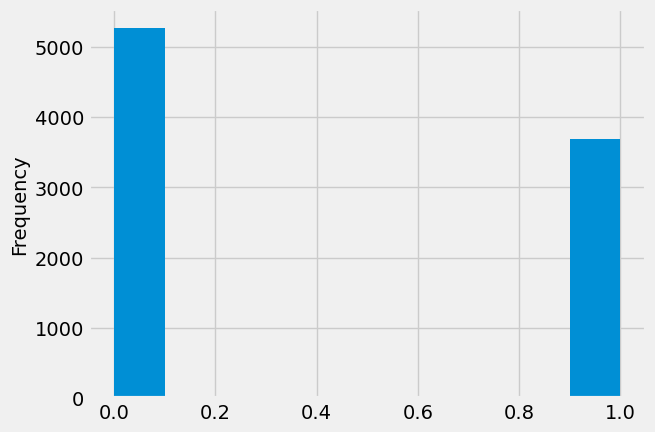

In [270]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

X = X_train
y = y_train

resampling_pipeline = Pipeline([
('over', SMOTE(sampling_strategy=0.1, random_state=42)),
('under', RandomUnderSampler(sampling_strategy=0.7, random_state=42))
])

X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)
y_resampled.astype(int).plot.hist();

In [271]:
X_train_hybrid = X_resampled.copy()
y_train_hybrid = y_resampled.copy()
X_test_hybrid = X_test.copy()
y_test_hybrid = y_test.copy()

In [272]:
X_train_CSV_hybrid = 'X_train_CSV_hybrid.csv'
X_test_CSV_hybrid = 'X_test_CSV_hybrid.csv'
y_train_CSV_hybrid = 'y_train_CSV_hybrid.csv'
y_test_CSV_hybrid = 'y_test_CSV_hybrid.csv'

X_train_hybrid.to_csv(X_train_CSV_hybrid, index=False)
X_test_hybrid.to_csv(X_test_CSV_hybrid, index=False)
y_train_hybrid.to_csv(y_train_CSV_hybrid, index=False)
y_test_hybrid.to_csv(y_test_CSV_hybrid, index=False)

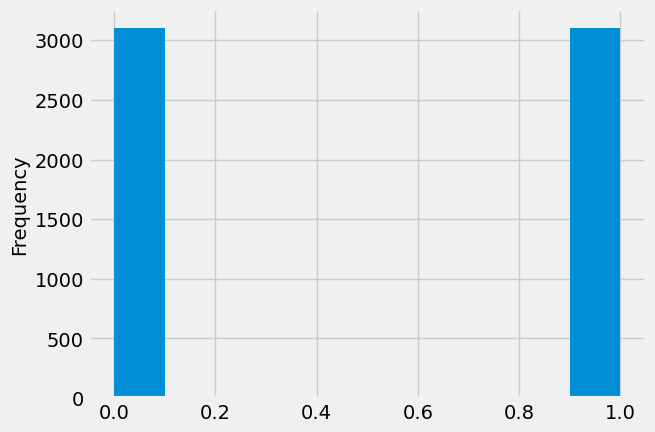

In [273]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

X = X_train
y = y_train
under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)
y_resampled.astype(int).plot.hist();

In [274]:
X_train_under = X_resampled.copy()
y_train_under = y_resampled.copy()
X_test_under = X_test.copy()
y_test_under = y_test.copy()

In [275]:
X_train_CSV_under = 'X_train_CSV_under.csv'
X_test_CSV_under = 'X_test_CSV_under.csv'
y_train_CSV_under = 'y_train_CSV_under.csv'
y_test_CSV_under = 'y_test_CSV_under.csv'

X_train_under.to_csv(X_train_CSV_under, index=False)
X_test_under.to_csv(X_test_CSV_under, index=False)
y_train_under.to_csv(y_train_CSV_under, index=False)
y_test_under.to_csv(y_test_CSV_under, index=False)